# 3.2 Modelo ML Supervisado de Regresión "Views"
3.2.1 Preparación dataset

3.2.2 Modelo logístico

3.2.3 Árbol de decisión

3.2.4 Random forrest

3.2.5 XGBOOST

3.2.5.1 Fine tunning y SHAP

3.2.6 Red Neuronal

3.2.7.1 Análaisis de variables

In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns        
import matplotlib.pyplot as plt 
import glob
import os
import time    
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler, Normalizer
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from scipy import sparse
from xgboost.callback import EarlyStopping
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_predict
import shap
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


/opt/anaconda3/envs/yt-ml-spvd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval_regression(model, X_train, X_test, y_train, y_test, print_digits=3, include_mape=True):
    """
    Evalúa un modelo de regresión ya entrenado sobre train y test.
    Retorna un diccionario con métricas y las imprime formateadas.

    Parámetros:
    - model: estimador sklearn (ya .fit)
    - X_train, X_test, y_train, y_test: conjuntos de datos
    - print_digits: nº de decimales al imprimir
    - include_mape: si True, calcula MAPE (ignora y==0 para evitar división por cero)
    """
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # --- MÉTRICAS ---
    # Train
    mae_tr  = mean_absolute_error(y_train, y_pred_train)
    mse_tr  = mean_squared_error(y_train, y_pred_train)
    rmse_tr = np.sqrt(mse_tr)
    r2_tr   = r2_score(y_train, y_pred_train)

    # Test
    mae_te  = mean_absolute_error(y_test, y_pred_test)
    mse_te  = mean_squared_error(y_test, y_pred_test)
    rmse_te = np.sqrt(mse_te)
    r2_te   = r2_score(y_test, y_pred_test)

    # MAPE (opcional, excluye y==0)
    mape_tr = mape_te = None
    if include_mape:
        mask_tr = (np.array(y_train) != 0)
        mask_te = (np.array(y_test)  != 0)
        if mask_tr.any():
            mape_tr = np.mean(np.abs((y_train[mask_tr] - y_pred_train[mask_tr]) / y_train[mask_tr])) * 100
        if mask_te.any():
            mape_te = np.mean(np.abs((y_test[mask_te] - y_pred_test[mask_te]) / y_test[mask_te])) * 100

    # Impresión bonita
    def r(x): 
        return None if x is None else round(x, print_digits)

    print(f"— TRAIN —  MAE: {r(mae_tr)} | MSE: {r(mse_tr)} | RMSE: {r(rmse_tr)} | R²: {r(r2_tr)}"
          + (f" | MAPE: {r(mape_tr)}%" if include_mape and mape_tr is not None else ""))
    print(f"— TEST  —  MAE: {r(mae_te)} | MSE: {r(mse_te)} | RMSE: {r(rmse_te)} | R²: {r(r2_te)}"
          + (f" | MAPE: {r(mape_te)}%" if include_mape and mape_te is not None else ""))

    return {
        "train": {"MAE": mae_tr, "MSE": mse_tr, "RMSE": rmse_tr, "R2": r2_tr, "MAPE": mape_tr},
        "test":  {"MAE": mae_te, "MSE": mse_te, "RMSE": rmse_te, "R2": r2_te, "MAPE": mape_te},
        "y_pred_train": y_pred_train,
        "y_pred_test": y_pred_test
    }

### 3.2.1. PREPARACIÓN DATASET

In [3]:
df_1=pd.read_parquet("../DATA/PROCESSED/df_TFMYouTube_embeddings_UMAP5_CLUSTERS_UMAP2.parquet")

In [4]:
cols= ['category_id','duration_minutes', "comments","views","has_caption","licensed_content","definition","tags_count","likes",
    "channel_video_count","channel_age_days","frecuencia_videos","channel_views","subscriber_count",'embedding_joint',"channel_id"]
df_1=df_1[cols]

In [5]:
df_1["views_per_subscriber"] = df_1["channel_views"] / df_1["subscriber_count"].replace(0, np.nan)

num_cols = [
    "duration_minutes",#"views_per_subscriber",
    "has_caption","licensed_content","definition",
    "frecuencia_videos"
]

cols_used = list(set(num_cols + ["category_id", "embedding_joint"]))

In [6]:

y = np.log1p(df_1["views"])# (df_1["views"]) # en escala lineal / provar: 
X = df_1[cols_used].copy()
channels = df_1["channel_id"].unique()
train_ch, test_ch = train_test_split(channels, test_size=0.2, random_state=42)
mask_tr = df_1["channel_id"].isin(train_ch)
mask_te = df_1["channel_id"].isin(test_ch)

X_train, y_train = X[mask_tr], y[mask_tr]
X_test,  y_test  = X[mask_te], y[mask_te]


In [7]:
# Asegurar que las columnas de embeddings existen
assert 'embedding_joint' in X.columns, \
       "Faltan columnas de embeddings en X."

num_cols = num_cols  # tus columnas numéricas
cat_cols = ['category_id']  # o las que correspondan

# --- pipes por bloque ---
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    #("robust", RobustScaler()),               # mitiga outliers
    ("pt", PowerTransformer(method="yeo-johnson", standardize=True)),  # transforma a distribución normal
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, min_frequency=10)),
])

# Helper para embeddings: apilar la serie de arrays (n,1) -> (n, d)
def stack_array_col(X):
    # X llega como DataFrame (n,1) con cada celda = np.ndarray
    return np.vstack(X.iloc[:, 0].to_numpy()).astype("float32")

# Pipeline para embedding_joint
emb_joint_pipe = Pipeline([
    ("stack", FunctionTransformer(stack_array_col, validate=False)),
    ("pca", PCA(n_components=50, random_state=42)),  # ajusta n_components según dataset
])

# --- ColumnTransformer completo ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
        ("emb", emb_joint_pipe, ["embedding_joint"]),
    ],
    remainder="drop",
    sparse_threshold=0.3, 
)


### 3.2.2. REGRESION LOGISTICA

In [8]:

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),   # tu ColumnTransformer ya definido
    ('model', LinearRegression())
])

# 2) CV por canal dentro de TRAIN
groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 # pasa el objeto, no el generador .split(...)
    groups=groups,          # MUY importante para agrupar por canal
    scoring="r2",
    n_jobs=-1
)
#print(f"CV R² (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

# 3) Entrena en TODO el train y evalúa en test hold-out
pipeline_power.fit(X_train, y_train)
y_pred_test = pipeline_power.predict(X_test)


eval_regression(pipeline_power,X_train, X_test, y_train, y_test)

— TRAIN —  MAE: 1.219 | MSE: 2.507 | RMSE: 1.583 | R²: 0.282 | MAPE: 16.721%
— TEST  —  MAE: 1.22 | MSE: 2.548 | RMSE: 1.596 | R²: 0.251 | MAPE: 16.219%


{'train': {'MAE': 1.2188752188594063,
  'MSE': 2.507107034017569,
  'RMSE': 1.5833846765765953,
  'R2': 0.28216676800919316,
  'MAPE': 16.72080735658184},
 'test': {'MAE': 1.2199642124504455,
  'MSE': 2.547665877045421,
  'RMSE': 1.5961409327015648,
  'R2': 0.25067215643000085,
  'MAPE': 16.21870624989635},
 'y_pred_train': array([ 8.77424454, 10.18440974,  8.99112224, ...,  9.45106295,
         8.61673811,  9.18062451]),
 'y_pred_test': array([10.04263968,  9.10101786,  9.81429767, ...,  8.23092568,
         9.56860806,  6.38744358])}

### 3.2.3. ARBOL DECISION

In [9]:
tree_clf = DecisionTreeRegressor(
   # criterion="log_loss",        # o "entropy"/"log_loss"
    max_depth=6,             # prueba 6–12 según tu data
    min_samples_leaf=18,     # sube/baja para controlar sobreajuste
   # class_weight="balanced", # importante con tu desbalance
    random_state=42
)

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', tree_clf)
])
groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 # pasa el objeto, no el generador .split(...)
    groups=groups,          # MUY importante para agrupar por canal
    scoring="r2",
    n_jobs=-1
)



pipeline_power.fit(X_train, y_train)
y_pred_test = pipeline_power.predict(X_test)



eval_regression(pipeline_power,X_train, X_test, y_train, y_test)


— TRAIN —  MAE: 1.134 | MSE: 2.271 | RMSE: 1.507 | R²: 0.35 | MAPE: 15.525%
— TEST  —  MAE: 1.211 | MSE: 2.612 | RMSE: 1.616 | R²: 0.232 | MAPE: 16.274%


{'train': {'MAE': 1.1338814969020694,
  'MSE': 2.271217991153379,
  'RMSE': 1.50705606768739,
  'R2': 0.3497063631413063,
  'MAPE': 15.525061817415962},
 'test': {'MAE': 1.2112574778670862,
  'MSE': 2.612242056290512,
  'RMSE': 1.6162431921869036,
  'R2': 0.23167879879401798,
  'MAPE': 16.27395087027093},
 'y_pred_train': array([ 9.04021849, 11.50392849,  9.37494701, ...,  9.04021849,
         8.60898299,  9.92541147]),
 'y_pred_test': array([ 9.28447914,  9.37494701,  9.49626957, ...,  8.23469172,
        11.18558227,  8.23469172])}

### 3.2.4 RANDOM FORREST

In [10]:

rf = RandomForestRegressor(random_state=42, n_estimators=50,n_jobs=-1) 

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', rf)
])

groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
assert len(groups) == len(X_train)
gkf = GroupKFold(n_splits=5)

cv_scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,
    groups=groups,
    scoring="r2",
    n_jobs=-1
)

pipeline_power.fit(X_train, y_train)
y_pred_test = pipeline_power.predict(X_test)


eval_regression(pipeline_power,X_train, X_test, y_train, y_test)


— TRAIN —  MAE: 0.397 | MSE: 0.29 | RMSE: 0.539 | R²: 0.917 | MAPE: 5.354%
— TEST  —  MAE: 1.151 | MSE: 2.334 | RMSE: 1.528 | R²: 0.313 | MAPE: 15.39%


{'train': {'MAE': 0.3969265537538549,
  'MSE': 0.29033319830407295,
  'RMSE': 0.5388257587607268,
  'R2': 0.9168719902002477,
  'MAPE': 5.353658729046532},
 'test': {'MAE': 1.1513342943299834,
  'MSE': 2.3341916183709106,
  'RMSE': 1.5278061455469116,
  'R2': 0.31345990554244985,
  'MAPE': 15.38988220481394},
 'y_pred_train': array([ 7.2176949 , 12.41445806,  8.32128508, ...,  8.09660952,
         8.42205674,  9.91476072]),
 'y_pred_test': array([ 8.69592158,  9.05471545,  9.59155456, ...,  8.1827702 ,
        10.60566752,  7.81230648])}

### 3.2.5 XGBOOST

In [11]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=16,
    subsample=0.7,
    colsample_bytree=0.6,
    colsample_bynode=0.8,
    gamma=0.2,
    reg_alpha=2.0,
    reg_lambda=10.0,
    tree_method="hist",
    max_bin=256,
    n_jobs=-1,
    random_state=42
)


pipeline_power = Pipeline([
    ("preprocessing", preprocessor),
    ("model", xgb)
])

# ----- espacio compacto, anti-overfit -----
param_dist = {
    "model__n_estimators":      [800, 1000, 1200, 1400],
    "model__learning_rate":     [0.02, 0.03, 0.05],
    "model__max_depth":         [4, 5],
    "model__min_child_weight":  [12, 16, 20, 24],
    "model__subsample":         [0.6, 0.7, 0.8],
    "model__colsample_bytree":  [0.5, 0.6, 0.7],
    "model__colsample_bynode":  [0.6, 0.8],
    "model__gamma":             [0.0, 0.2, 0.5],
    "model__reg_alpha":         [1.0, 2.0, 4.0],
    "model__reg_lambda":        [5.0, 10.0, 15.0],
}

# ----- CV agrupado por canal -----
groups = df_1.loc[mask_tr, "channel_id"]
gkf = GroupKFold(n_splits=5)

# ----- scorer oficial RMSE (negativo, sklearn maximiza) -----
neg_rmse = "neg_root_mean_squared_error"

xgb_search = RandomizedSearchCV(
    estimator=pipeline_power,
    param_distributions=param_dist,
    n_iter=25,
    scoring=neg_rmse,
    cv=gkf.split(X_train, y_train, groups=groups),
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# ----- entrenamiento de la búsqueda -----
xgb_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", xgb_search.best_params_)
best_model = xgb_search.best_estimator_

# 6) Métricas
y_pred_test = best_model.predict(X_test)


eval_regression(best_model, X_train, X_test, y_train, y_test)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END model__colsample_bynode=0.6, model__colsample_bytree=0.7, model__gamma=0.0, model__learning_rate=0.02, model__max_depth=4, model__min_child_weight=20, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=5.0, model__subsample=0.6; total time=   3.0s
[CV] END model__colsample_bynode=0.6, model__colsample_bytree=0.7, model__gamma=0.0, model__learning_rate=0.02, model__max_depth=4, model__min_child_weight=20, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=5.0, model__subsample=0.6; total time=   3.2s
[CV] END model__colsample_bynode=0.6, model__colsample_bytree=0.7, model__gamma=0.0, model__learning_rate=0.02, model__max_depth=4, model__min_child_weight=20, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=5.0, model__subsample=0.6; total time=   3.2s
[CV] END model__colsample_bynode=0.6, model__colsample_bytree=0.7, model__gamma=0.0, model__learning_rate=0.02, model__max

{'train': {'MAE': 0.8611776503105839,
  'MSE': 1.2886080209203596,
  'RMSE': 1.135168719142824,
  'R2': 0.6310466015707981,
  'MAPE': 11.54062560285313},
 'test': {'MAE': 1.1131534735859347,
  'MSE': 2.176931186992555,
  'RMSE': 1.4754427088140545,
  'R2': 0.3597138594009094,
  'MAPE': 14.868984753833},
 'y_pred_train': array([ 8.361857, 10.988611,  8.758206, ...,  8.818932,  8.706238,
         9.735866], dtype=float32),
 'y_pred_test': array([10.056309,  9.320282,  9.27681 , ...,  8.236793, 10.297061,
         7.428187], dtype=float32)}

SHAP- DISTINCION VARIABLE XGBOOST


Top-20 features por |SHAP| medio:


,feature,mean_abs_shap
0,emb_1,0.429668
1,duration_minutes,0.298343
2,emb_4,0.170307
3,licensed_content,0.162570
4,emb_5,0.124459
5,emb_9,0.115116
6,frecuencia_videos,0.106889
7,category_id_10.0,0.088670
8,emb_8,0.086657
9,emb_0,0.065248


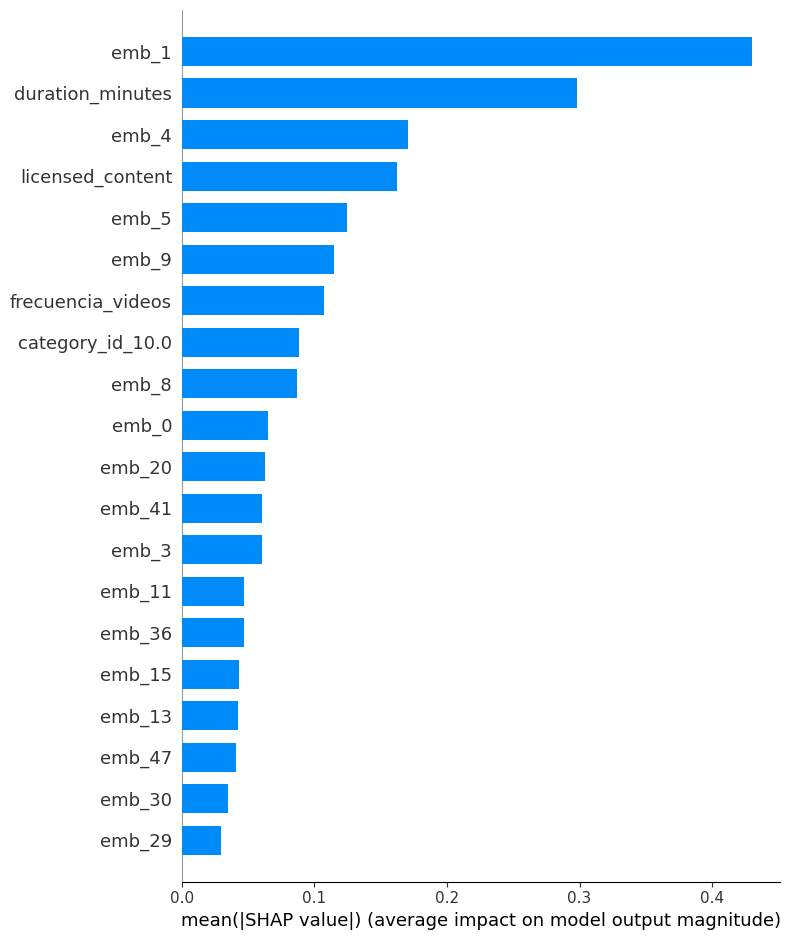

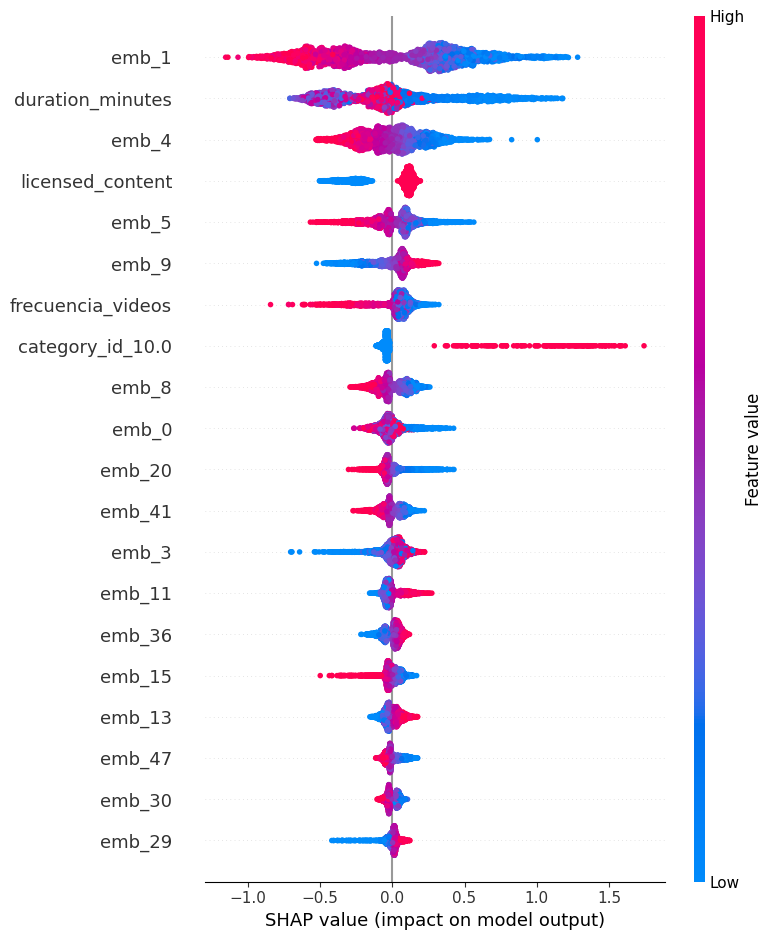

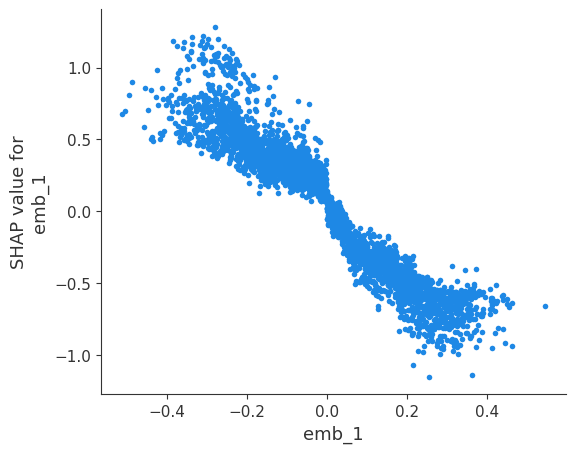

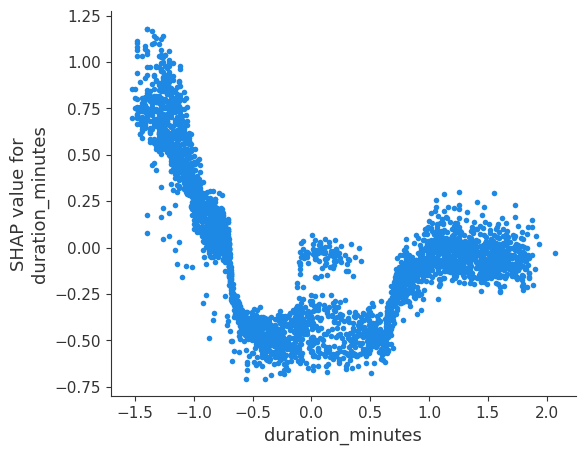

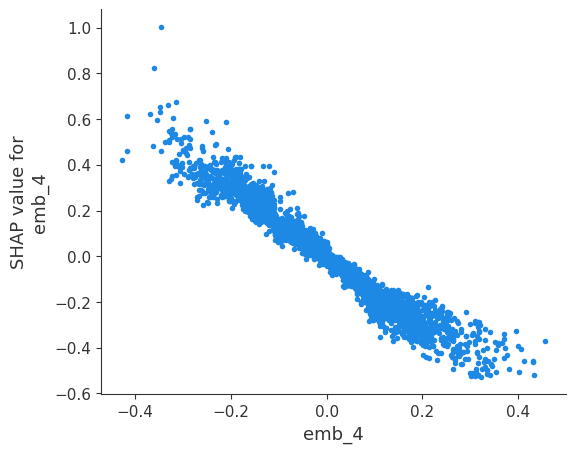

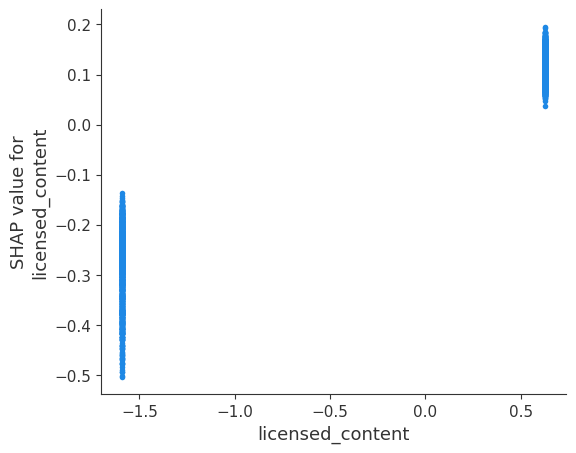

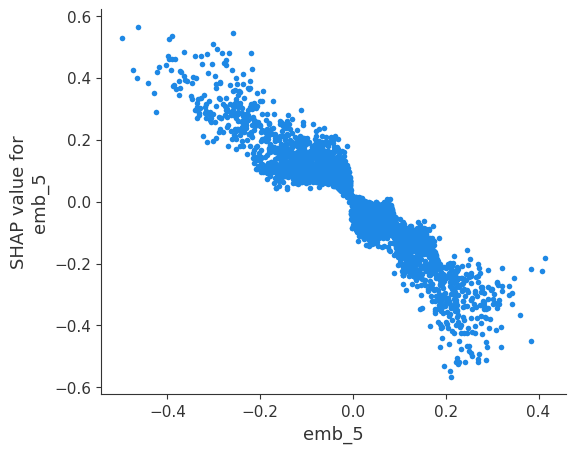

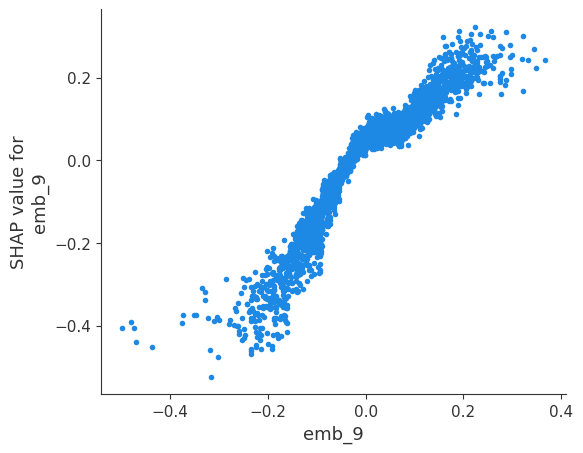

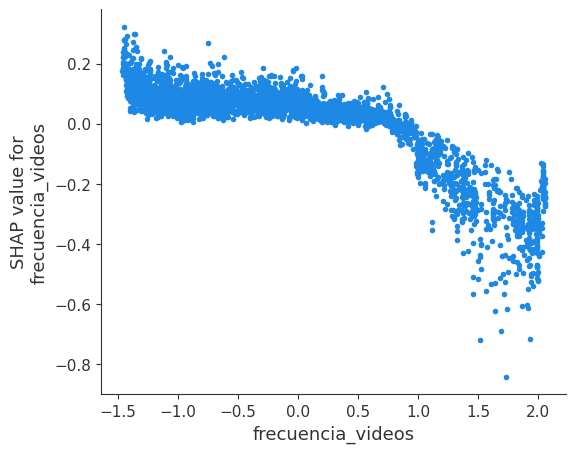

In [12]:
def _resolve_cols(cols, X_sample: pd.DataFrame):
    if callable(cols): 
        cols = cols(X_sample)
    if isinstance(cols, slice): 
        return list(X_sample.columns[cols])
    if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
        if len(cols) > 0 and isinstance(cols[0], (int, np.integer)):
            return list(X_sample.columns[list(cols)])
        if isinstance(cols, (np.ndarray, pd.Index)) and getattr(cols, "dtype", None) == bool:
            return list(X_sample.columns[cols])
        return list(cols)
    return [cols]

def get_ct_feature_names_compat(ct, X_sample: pd.DataFrame):
    """
    Devuelve nombres de salida de un ColumnTransformer 'ct' ya AJUSTADO.
    - Usa get_feature_names_out cuando esté disponible.
    - Para 'passthrough', devuelve los nombres originales.
    - Para trafos opacos, infiere n_cols transformando una muestra.
    """
    out = []
    if not hasattr(ct, "transformers_"):
        raise RuntimeError("ColumnTransformer no está ajustado. Ajusta el pipeline o el CT antes.")

    for name, trans, cols in ct.transformers_:
        if trans == "drop":
            continue
        cols_res = _resolve_cols(cols, X_sample)

        # 1) Transformador con nombres propios
        if hasattr(trans, "get_feature_names_out"):
            try:
                feats = trans.get_feature_names_out(cols_res)
                out.extend(list(feats))
                continue
            except Exception:
                pass

        # 2) Passthrough
        if trans == "passthrough":
            out.extend(cols_res)
            continue

        # 3) Caso opaco: inferir nº de columnas
        X_slice = X_sample[cols_res]
        try:
            Xt = trans.transform(X_slice)
        except Exception:
            n = min(50, len(X_slice))
            Xt = trans.transform(X_slice.iloc[:n])

        Xt = Xt.toarray() if sparse.issparse(Xt) else np.asarray(Xt)
        n_out = Xt.shape[1] if Xt.ndim > 1 else 1
        out.extend([f"{name}_{i}" for i in range(n_out)])

    return np.array(out, dtype=object)

# ========= 1) Toma el pipeline ya entrenado =========
best_pipe = xgb_search.best_estimator_          # <- ESTE sí es un Pipeline fitted
ct = best_pipe.named_steps["preprocessing"]     # ColumnTransformer fitted
model = best_pipe.named_steps["model"]          # XGBRegressor o XGBClassifier fitted

# Si en algún momento activaste salida pandas, aquí usa salida "default" para evitar conflictos con OHE sparse
try:
    ct.set_output(transform="default")
except Exception:
    pass

# ========= 2) Transforma X_test y arma DataFrame denso con nombres =========
X_sample = X_train.iloc[: min(100, len(X_train))].copy()  # para resolver nombres de forma estable
feat_names = get_ct_feature_names_compat(ct, X_sample)

Xt = ct.transform(X_test)  # puede ser sparse
Xt = Xt.toarray() if sparse.issparse(Xt) else np.asarray(Xt)
X_test_df = pd.DataFrame(Xt, columns=feat_names)

# ========= 3) SHAP: TreeExplainer para XGBoost =========
# Para versiones nuevas de shap/xgboost, también sirve shap.Explainer(model)
try:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_df)  # array (n_samples, n_features)
except Exception:
    # fallback genérico
    explainer = shap.Explainer(model)
    sv = explainer(X_test_df)
    shap_values = sv.values  # (n_samples, n_features)

# ========= 4) Top-20 por |SHAP| medio =========
mean_abs = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(-mean_abs)[:20]
top_df = (pd.DataFrame({"feature": X_test_df.columns[top_idx], "mean_abs_shap": mean_abs[top_idx]})
          .sort_values("mean_abs_shap", ascending=False)
          .reset_index(drop=True))

print("\nTop-20 features por |SHAP| medio:")
display(top_df)

# ========= 5) Plots globales =========
# Ranking global
shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=20, show=True)
# Beeswarm: dirección (color) + intensidad (magnitud)
shap.summary_plot(shap_values, X_test_df, max_display=20, show=True)

# ========= 6) Plots de dependencia para las 5 más influyentes =========
for feat in top_df["feature"].head(7):
    try:
        shap.dependence_plot(feat, shap_values, X_test_df, interaction_index=None, show=True)
    except Exception as e:
        print(f"Dependence plot falló para {feat}: {e}")

## 3.2.6. RED NEURONAL

In [13]:
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),   # capas ocultas: prueba también (64,) o (256,128,64)
    activation="relu",              # función de activación
    solver="adam",                  # optimizador
    alpha=1e-4,                     # regularización L2
    batch_size=256,                 # tamaño del batch
    learning_rate_init=1e-3,        # tasa de aprendizaje inicial
    max_iter=200,                   # épocas máximas
    early_stopping=True,            # para parar si no mejora
    n_iter_no_change=10,            # paciencia para early stopping
    validation_fraction=0.2,        # parte de train usada como validación
    random_state=42,
    verbose=True                    # muestra progreso en entrenamiento
)


pipeline_power = Pipeline(
    steps=[
    ('preprocessing', preprocessor),
    ('model', mlp),
  #  ("to_dense", FunctionTransformer(to_dense))
])

groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 # pasa el objeto, no el generador .split(...)
    groups=groups,          # MUY importante para agrupar por canal
    scoring="r2",
    n_jobs=-1
)
pipeline_power.fit(X_train, y_train)
y_pred_test = pipeline_power.predict(X_test)


eval_regression(pipeline_power,X_train, X_test, y_train, y_test)

Iteration 1, loss = 23.96700752
Validation score: -3.459868
Iteration 2, loss = 2.85330836
Validation score: 0.063072
Iteration 3, loss = 1.45327672
Validation score: 0.205153
Iteration 4, loss = 1.31742384
Validation score: 0.236390
Iteration 1, loss = 23.74289739
Validation score: -3.390673
Iteration 5, loss = 1.26156902
Validation score: 0.254811
Iteration 2, loss = 2.91516438
Validation score: 0.047889
Iteration 6, loss = 1.22554027
Validation score: 0.268572
Iteration 1, loss = 23.91423156
Validation score: -3.152926
Iteration 3, loss = 1.46798117
Validation score: 0.173629
Iteration 7, loss = 1.19841251
Iteration 2, loss = 2.93333666
Validation score: 0.276864
Validation score: 0.086558
Iteration 1, loss = 23.78744500
Validation score: -3.254580
Iteration 4, loss = 1.31947445
Iteration 8, loss = 1.17543290
Validation score: 0.214940
Iteration 3, loss = 1.47909708
Validation score: 0.285595
Validation score: 0.217408
Iteration 5, loss = 1.26087106
Iteration 2, loss = 2.84296464
Va

{'train': {'MAE': 0.9299433049122807,
  'MSE': 1.520214431909901,
  'RMSE': 1.232969761149843,
  'R2': 0.5647332067716957,
  'MAPE': 12.256893403388894},
 'test': {'MAE': 1.1543290732522855,
  'MSE': 2.3008100686140445,
  'RMSE': 1.5168421370116418,
  'R2': 0.32327819644146916,
  'MAPE': 15.119410259632707},
 'y_pred_train': array([ 7.94901251, 11.24133436,  8.67551915, ...,  8.9248528 ,
         8.35678386,  9.22049287]),
 'y_pred_test': array([10.61634697,  8.42137152,  9.79446553, ...,  8.23730199,
        10.45863001,  7.58724231])}

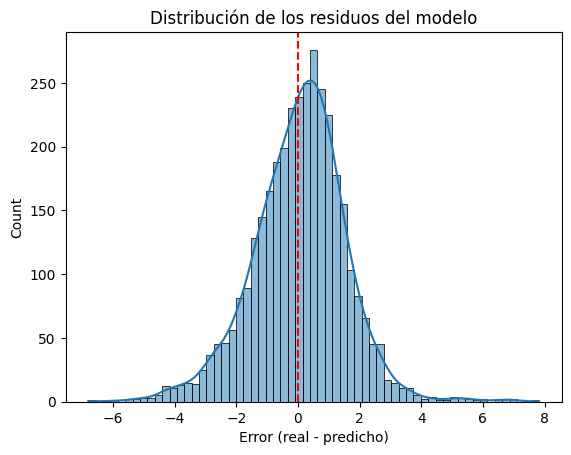

In [15]:
residuos = y_test - y_pred_test
sns.histplot(residuos, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribución de los residuos del modelo')
plt.xlabel('Error (real - predicho)')
plt.show()

In [16]:
df_2=pd.read_parquet("../DATA/PROCESSED/df_TFMYouTube_embeddings_UMAP5_CLUSTERS_UMAP2.parquet")
df_1[["umap2_x", "umap2_y","cluster_umap5", "views", "likes", "comments", "engagement_rate",]] = df_2[["umap2_x", "umap2_y","cluster_umap5", "views", "likes", "comments", "engagement_rate"]]

best_pipe = xgb_search.best_estimator_  # o joblib.load("models/mostpopular/artifacts/model.joblib")

# Localiza el PCA que procesa 'embedding_joint' dentro del preprocessor
pre = best_pipe.named_steps["preprocessing"]

# Ajuste de nombres a configuración real
pca = pre.named_transformers_["emb"].named_steps["pca"]   # e.g. Pipeline([("scaler", ...), ("pca", PCA(...))])

# Prepara la matriz a partir de la columna 'embedding_joint'
def to_vec(x):
    # x puede venir como lista, np.array o string de lista -> normalízalo
    if isinstance(x, str):
        import ast
        return np.array(ast.literal_eval(x), dtype=float)
    return np.array(x, dtype=float)

E = np.vstack(df_1["embedding_joint"].apply(to_vec).values)  # shape: (n_samples, d)

# Transforma con el PCA ya entrenado
Z = pca.transform(E)  # shape: (n_samples, n_components)

# Vuelca a columnas emb_1..emb_k
k = Z.shape[1]
emb_cols = [f"emb_{i+1}" for i in range(k)]
df_1[emb_cols] = Z

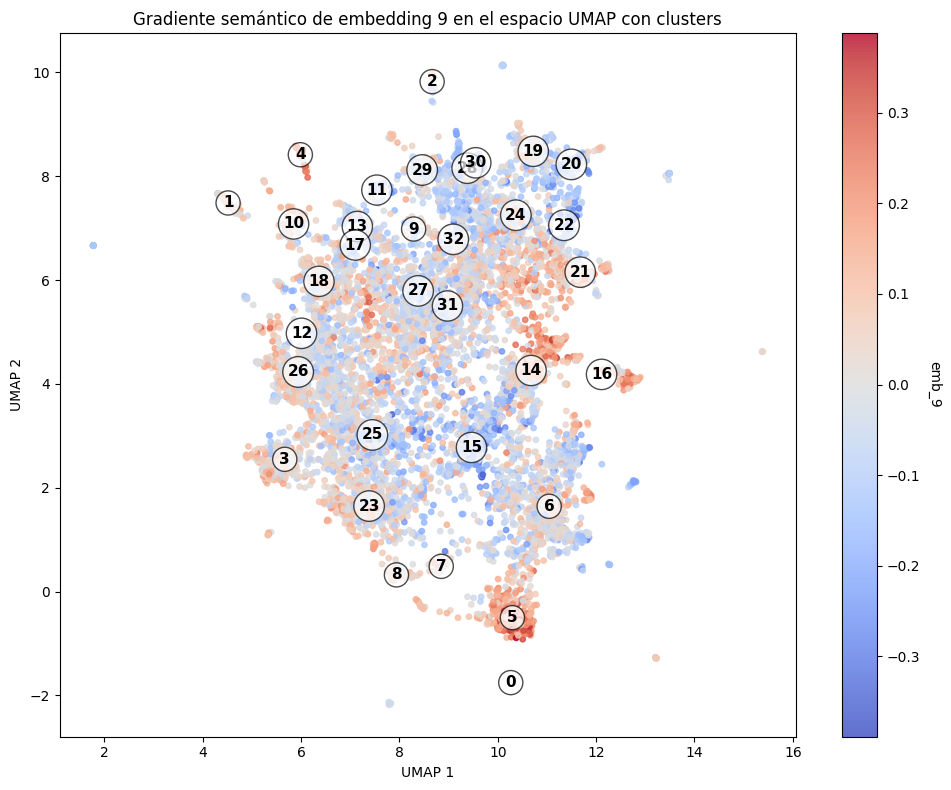

In [17]:
df_plot = df_1.sample(min(8000, len(df_1)), random_state=42)

# Figura base
plt.figure(figsize=(10, 8))


sc = plt.scatter(
    df_plot["umap2_x"], df_plot["umap2_y"],
    c=df_plot["emb_9"], cmap="coolwarm", s=15, alpha=0.8
)


cbar = plt.colorbar(sc)
cbar.set_label("emb_9", rotation=270, labelpad=15)


centroids = (
    df_1[df_1["cluster_umap5"] != -1]  # excluye ruido
    .groupby("cluster_umap5")[["umap2_x", "umap2_y"]]
    .mean()
    .reset_index()
)

for _, row in centroids.iterrows():
    plt.text(
        row["umap2_x"], row["umap2_y"],
        str(int(row["cluster_umap5"])),
        fontsize=11, fontweight="bold",
        ha="center", va="center",
        bbox=dict(facecolor="white", edgecolor="black", alpha=0.7, boxstyle="circle,pad=0.3")
    )

# Gráfica
plt.title("Gradiente semántico de embedding 9 en el espacio UMAP con clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_85801/2636737092.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


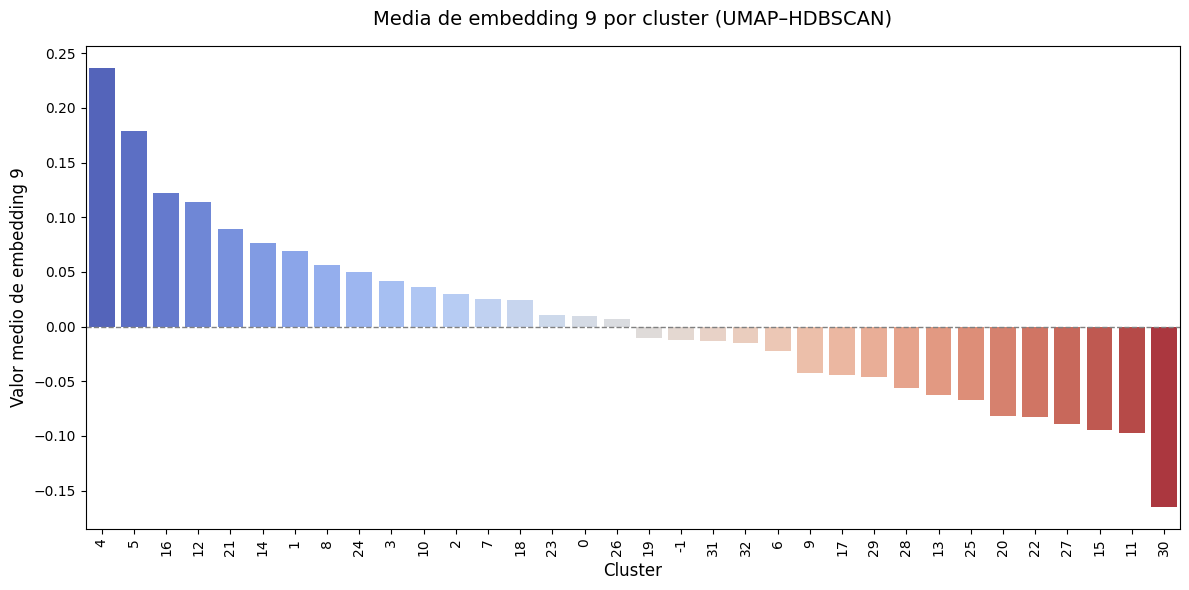

In [18]:
# Calcular la media del embedding 1 por cluster y ordenarla de mayor a menor
mean_emb9 = (
    df_1.groupby("cluster_umap5")["emb_9"]
        .mean()
        .sort_values(ascending=False)
)

# Graficar en el orden correcto
plt.figure(figsize=(12, 6))
sns.barplot(
    x=mean_emb9.index.astype(str),  # convertir a string para evitar errores con el orden
    y=mean_emb9.values,
    palette="coolwarm",
    order=mean_emb9.index.astype(str)  # mantener el orden de mayor a menor
)

# Línea base y etiquetas
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Media de embedding 9 por cluster (UMAP–HDBSCAN)", fontsize=14, pad=15)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Valor medio de embedding 9", fontsize=12)

# Rotación de etiquetas
plt.xticks(rotation=90, ha="center")

plt.tight_layout()
plt.show()

In [19]:
df_1.groupby("cluster_umap5")["emb_9"].mean().sort_values()


cluster_umap5
 30   -0.164947
 11   -0.097079
 15   -0.094856
 27   -0.088980
 22   -0.082918
 20   -0.081444
 25   -0.066764
 13   -0.062069
 28   -0.055981
 29   -0.046299
 17   -0.043819
 9    -0.042590
 6    -0.021850
 32   -0.015106
 31   -0.013484
-1    -0.012001
 19   -0.010747
 26    0.006548
 0     0.009655
 23    0.010635
 18    0.024263
 7     0.025374
 2     0.030075
 10    0.036261
 3     0.041409
 24    0.049721
 8     0.056193
 1     0.069103
 14    0.076192
 21    0.089457
 12    0.113983
 16    0.122459
 5     0.179034
 4     0.236690
Name: emb_9, dtype: float64

<Axes: >

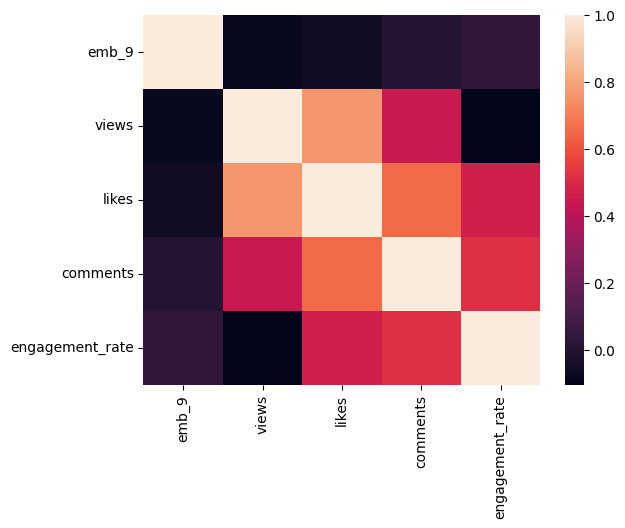

In [20]:
corr=df_1[["emb_9", "views", "likes", "comments", "engagement_rate"]].corr(method="spearman")
sns.heatmap(corr)